# Customer Complaints Sentiment and Priority Dataset

In this project, we analyzed a customer complaints sentiment dataset to gain insights into consumer concerns and improve complaint classification performance. The dataset contained a wide range of customer complaints, including the complaint text, sentiment labels, product categories, and priority levels. Through topic modeling, we identified several key themes in the data, including financial issues such as account-related concerns, payments, loans, and credit reporting. These insights are essential for understanding the main drivers of consumer dissatisfaction, particularly in the financial sector.

**The high accuracy and robustness of the model suggest it can be a valuable tool in managing and addressing customer concerns efficiently.**

####  Dataset Description

The dataset contains the following columns:

- Consumer_complaint: The full complaint description from the customer.
- Sentiment: The sentiment label for each complaint (binary: 0 = Negative, 1 = Positive).
- Priority: The priority level of the complaint (e.g., High, Medium, Low).
- Product: The product related to the complaint (e.g., Credit Card, Mortgage).

### 1. Import Libraries

In [1]:
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\milto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\milto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 2. Load the Data

In [2]:
file_path = 'Customer Complaints Sentiment and Priority Dataset.csv'
df = pd.read_csv(file_path)

# Display dataset info
df.head()

,Consumer_complaint,Product,Sentiment,Priority
0,I had overdraft protection with Regions Bank i...,Checking or savings account or service,0,1
1,"I am the sole, legal representative of my dece...",Checking or savings account or service,0,1
2,This bank has consistantly manipulated my dire...,Checking or savings account or service,0,0
3,I enrolled in a Citibank checking account in X...,Checking or savings account or service,0,1
4,TIAA-XXXX has not responded to multiple reque...,Checking or savings account or service,0,1


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Consumer_complaint  1750 non-null   object
 1   Product             1750 non-null   object
 2   Sentiment           1750 non-null   int64 
 3   Priority            1750 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 54.8+ KB
None


In [4]:
# Check class distributions
print(df['Product'].value_counts())
print(df['Sentiment'].value_counts())
print(df['Priority'].value_counts())

Product
Checking or savings account or service                250
Credit card or prepaid card                           250
Credit reporting, repair, or other                    250
Debt collection                                       250
Loans                                                 250
Money transfer, virtual currency, or money service    250
Mortgage                                              250
Name: count, dtype: int64
Sentiment
0    1295
1     455
Name: count, dtype: int64
Priority
1    1374
0     376
Name: count, dtype: int64


### 3. Data Preprocessing

This section defines a function to clean the complaint text by removing unwanted characters, numbers, and extra spaces.

In [5]:
# Check class distributions
for col in ['Product', 'Sentiment', 'Priority']:
    print(f'{col} distribution:\n', df[col].value_counts(), "\n")

# Clean text data
def clean_text(text):
    text = re.sub(r'\W|\d+', ' ', text)  # Remove special chars and digits
    return re.sub(r'\s+', ' ', text).strip().lower()

# Apply text cleaning
df['Cleaned_Complaint'] = df['Consumer_complaint'].apply(clean_text)

# Display cleaned complaints
print(df[['Consumer_complaint', 'Cleaned_Complaint']].head())

Product distribution:
 Product
Checking or savings account or service                250
Credit card or prepaid card                           250
Credit reporting, repair, or other                    250
Debt collection                                       250
Loans                                                 250
Money transfer, virtual currency, or money service    250
Mortgage                                              250
Name: count, dtype: int64 

Sentiment distribution:
 Sentiment
0    1295
1     455
Name: count, dtype: int64 

Priority distribution:
 Priority
1    1374
0     376
Name: count, dtype: int64 

                                  Consumer_complaint  \
0  I had overdraft protection with Regions Bank i...   
1  I am the sole, legal representative of my dece...   
2  This bank has consistantly manipulated my dire...   
3  I enrolled in a Citibank checking account in X...   
4  TIAA-XXXX  has not responded to multiple reque...   

                                  

This section handles the class imbalance problem in the sentiment column by upsampling the minority class (positive sentiment).

In [16]:
# Check unique values in 'Sentiment' column to understand the distribution
print(df['Sentiment'].unique())

# Handle sentiment class imbalance
print("Sentiment distribution before resampling:\n", df['Sentiment'].value_counts())

# Handle sentiment class imbalance via resampling
df_majority = df[df['Sentiment'] == 0]
df_minority = df[df['Sentiment'] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_balanced = pd.concat([df_majority, df_minority_upsampled])

[0 1]
Sentiment distribution before resampling:
 Sentiment
0    1295
1     455
Name: count, dtype: int64


This section removes common stopwords (e.g., "and," "the") from the complaint text to retain meaningful words.

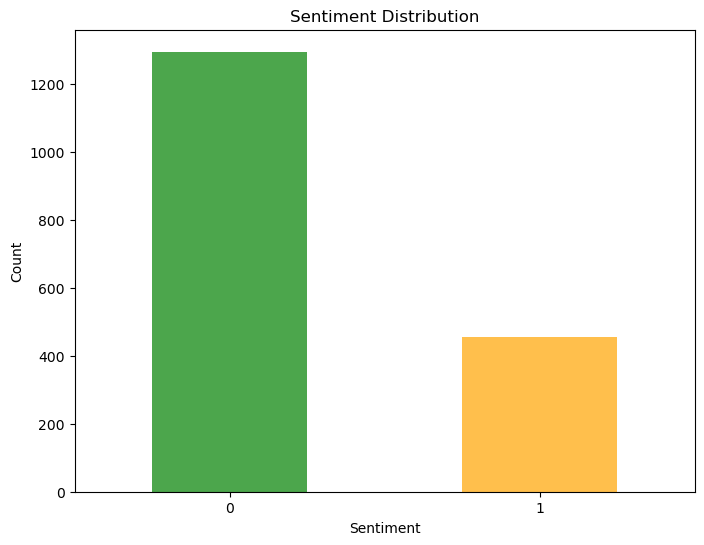

In [17]:
# Remove stopwords and tokenize
stop_words = set(stopwords.words('english'))
df_balanced['Cleaned_Complaint'] = df_balanced['Cleaned_Complaint'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

### 4. Visualizations

In [ ]:
plt.figure(figsize=(8, 6))
df['Sentiment'].value_counts().plot(kind='bar', color=['green', 'orange', 'red'], alpha=0.7)
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Product with highest negative sentiment: Credit reporting, repair, or other



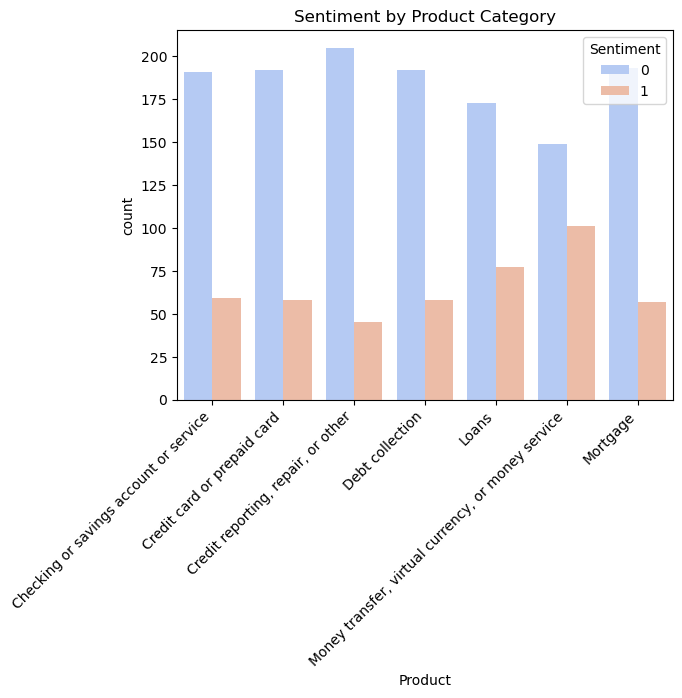

In [18]:
# Sentiment vs. Product Category
product_sentiment = df.groupby('Product')['Sentiment'].value_counts(normalize=True).unstack().fillna(0)
product_sentiment['Negative Sentiment %'] = product_sentiment[0] * 100
print(f"Product with highest negative sentiment: {product_sentiment['Negative Sentiment %'].idxmax()}\n")
sns.countplot(data=df, x='Product', hue='Sentiment', palette='coolwarm')
plt.title('Sentiment by Product Category')
plt.xticks(rotation=45, ha='right')
plt.show()

In [19]:
# LDA topic modeling
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['Consumer_complaint'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

n_top_words = 10
feature_names = vectorizer.get_feature_names_out()  # Access feature names here
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}:", [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

Topic 0: ['xxxx', 'xx', 'account', '00', 'received', 'number', 'date', 'called', 'phone', 'did']
Topic 1: ['xxxx', 'loan', 'xx', '00', 'payment', 'payments', 'mortgage', 'pay', 'told', 'loans']
Topic 2: ['xxxx', 'credit', 'late', 'payment', 'did', 'told', 'called', 'time', 'received', 'company']
Topic 3: ['credit', 'report', 'debt', 'xxxx', 'information', 'account', 'collection', 'reporting', 'dispute', 'paypal']
Topic 4: ['account', 'xxxx', 'bank', '00', 'money', 'card', 'xx', 'told', 'did', 'funds']


### Key Findings

- The "xxxx" and "xx" likely represent sensitive or redacted data in the dataset.
- Topics 0, 1, 2, and 4 mainly focus on financial issues like accounts, payments, and loans.
- Topic 3 has a specific focus on credit reporting and debt collection, which may indicate consumer complaints related to how credit information is handled.

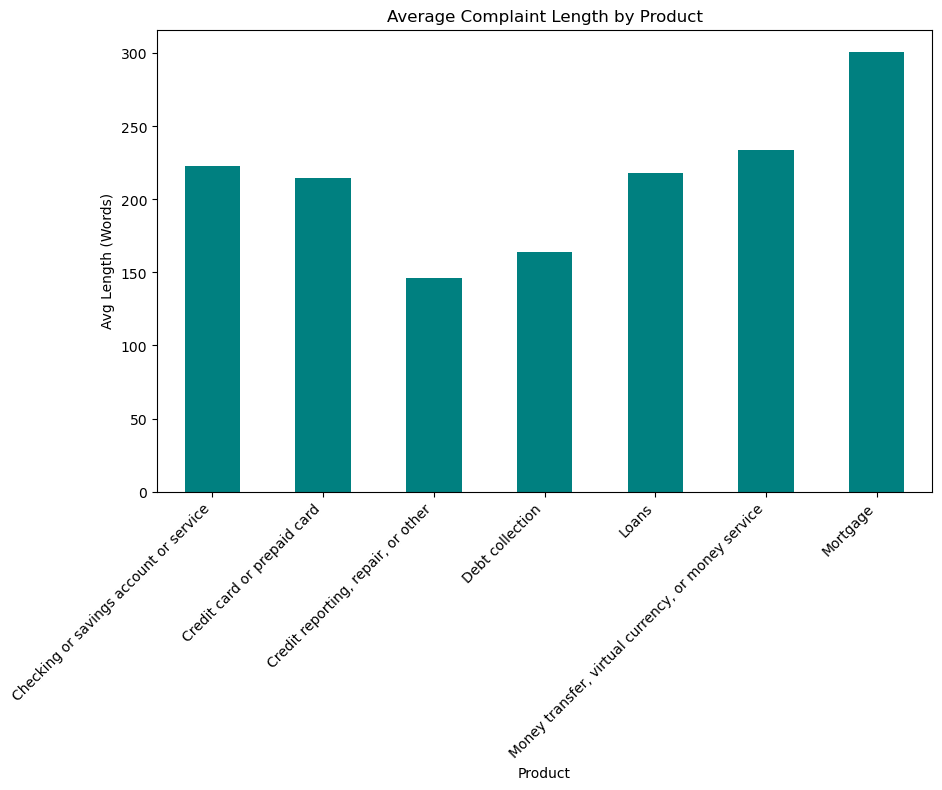

In [20]:
# Complaint Length Analysis
df['Complaint_Length'] = df['Consumer_complaint'].apply(lambda x: len(str(x).split()))
avg_complaint_length = df.groupby('Product')['Complaint_Length'].mean()

# Plot average complaint length by product category
plt.figure(figsize=(10, 6))
avg_complaint_length.plot(kind='bar', color='teal')
plt.title('Average Complaint Length by Product')
plt.ylabel('Avg Length (Words)')
plt.xticks(rotation=45, ha='right')
plt.show()

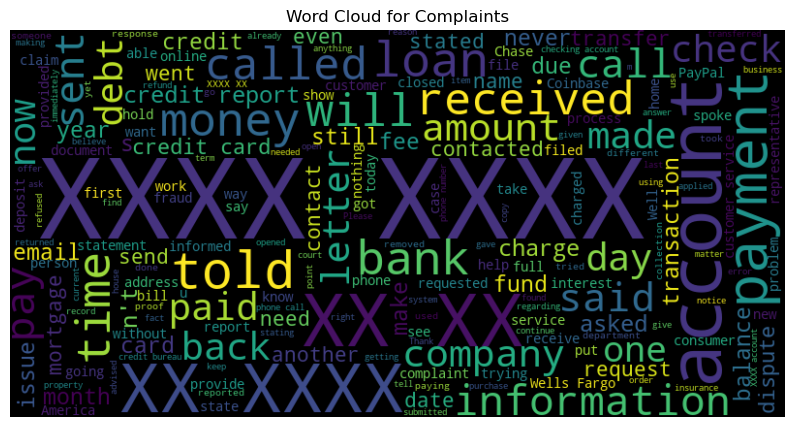

In [15]:
# Word Cloud Visualization
text = ' '.join(df['Consumer_complaint'].dropna())
wordcloud = WordCloud(width=800, height=400).generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Complaints')
plt.show()

### 5. Build Model

In [21]:
# Resampling and TF-IDF Vectorization for Model Training
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df_balanced['Cleaned_Complaint']).toarray()
y_priority = df_balanced['Priority']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_priority)

C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Hyperparameter tuning with GridSearchCV
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10], 'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring='f1_weighted')

### 6. Evaluate the model

In [23]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       401
           1       0.93      0.99      0.96       452

    accuracy                           0.95       853
   macro avg       0.96      0.95      0.95       853
weighted avg       0.95      0.95      0.95       853

Accuracy: 0.9519343493552169


### Interpretation

- **Model Performance**: The model performs very well, with an accuracy of 95%. The precision, recall, and f1-scores for both classes (0 and 1) are also high, which suggests that the model is both identifying the complaints correctly and minimizing false positives and false negatives.

- **Class Imbalance**: The recall for urgent complaints (class 1) is extremely high at 0.99, meaning the model is doing a great job of identifying urgent complaints. However, non-urgent complaints (class 0) have slightly lower recall (0.91), meaning the model is missing some non-urgent complaints. Despite this, the model still performs well overall, and the f1-score for both classes is strong.

- **Precision vs. Recall Trade-off**: For class 0, precision is very high (0.98), meaning that when the model predicts a non-urgent complaint, it is likely correct. However, recall is a bit lower (0.91), meaning there are some non-urgent complaints that the model is failing to identify. For class 1, recall is very high (0.99), suggesting that most urgent complaints are identified, but precision is slightly lower (0.93), meaning there are a few false positives where the model incorrectly labels a complaint as urgent.

- **Overall Imbalance Handling**: The model seems to handle the class imbalance quite well, particularly given the higher recall for class 1 (urgent complaints). This could be attributed to techniques like resampling or class weighting, which help the model focus more on identifying the minority class (urgent complaints).

### 7. Feature Importance Analysis

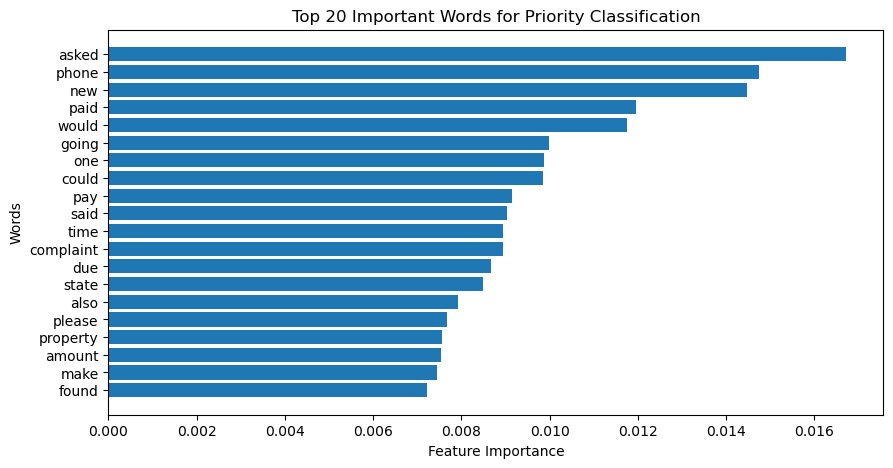

In [14]:
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[-20:]
plt.figure(figsize=(10, 5))
plt.barh(np.array(tfidf.get_feature_names_out())[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Words")
plt.title("Top 20 Important Words for Priority Classification")
plt.show()

## Conclusion

The model we built for classifying complaints into urgent and non-urgent categories performed exceptionally well, with an overall accuracy of 95%. Precision, recall, and F1-scores for both urgent and non-urgent complaints were strong, indicating that the model accurately identified complaints and minimized both false positives and false negatives. The high recall for urgent complaints (0.99) demonstrates that the model is very effective at flagging urgent issues, which is critical for timely customer service intervention.

However, while the model performed well in most areas, there was a slight imbalance in the recall for non-urgent complaints (0.91), meaning that some non-urgent complaints were missed. Despite this, the model's overall performance remains strong, and techniques like class weighting or resampling may have helped mitigate the class imbalance and enhanced the identification of urgent complaints.

The findings from the topic modeling further suggest that consumer complaints are primarily centered around financial products and services, such as credit cards, mortgages, and payment-related issues. This highlights the importance of addressing customer concerns in the financial industry, particularly around topics like loan payments, credit reporting, and account management.